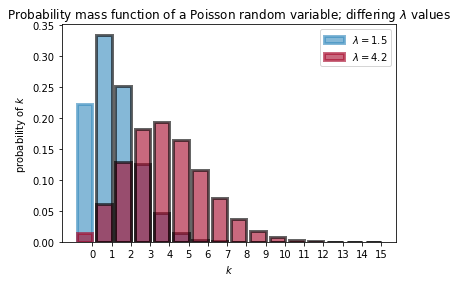

In [6]:
%matplotlib inline

from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colours = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
        label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
        edgecolor=colours[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
        label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values");

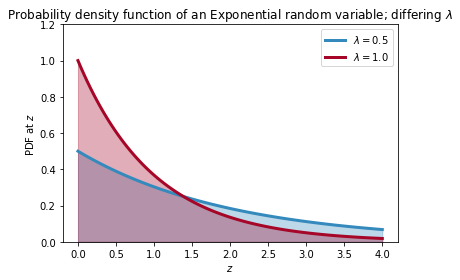

In [5]:

a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1. / l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1. / l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0, 1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

In [8]:
count_data = np.loadtxt("datatxtdata.csv")

In [9]:
count_data

array([ 13.,  24.,   8.,  24.,   7.,  35.,  14.,  11.,  15.,  11.,  22.,
        22.,  11.,  57.,  11.,  19.,  29.,   6.,  19.,  12.,  22.,  12.,
        18.,  72.,  32.,   9.,   7.,  13.,  19.,  23.,  27.,  20.,   6.,
        17.,  13.,  10.,  14.,   6.,  16.,  15.,   7.,   2.,  15.,  15.,
        19.,  70.,  49.,   7.,  53.,  22.,  21.,  31.,  19.,  11.,  18.,
        20.,  12.,  35.,  17.,  23.,  17.,   4.,   2.,  31.,  30.,  13.,
        27.,   0.,  39.,  37.,   5.,  14.,  13.,  22.])

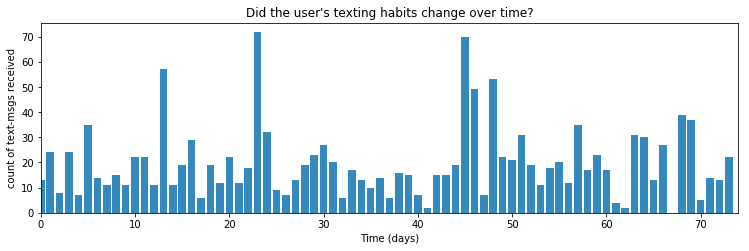

In [11]:
figsize(12.5, 3.5)
count_data = np.loadtxt("datatxtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [12]:
import pymc as pm

alpha = 1.0 / count_data.mean()  # Recall count_data is the
                               # variable that holds our txt counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [14]:
print("Random output:", tau.random(), tau.random(), tau.random())

Random output: 11 74 28


In [15]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

In [16]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [17]:
# Mysterious code to be explained in Chapter 3.
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 5.7 sec

In [18]:

lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

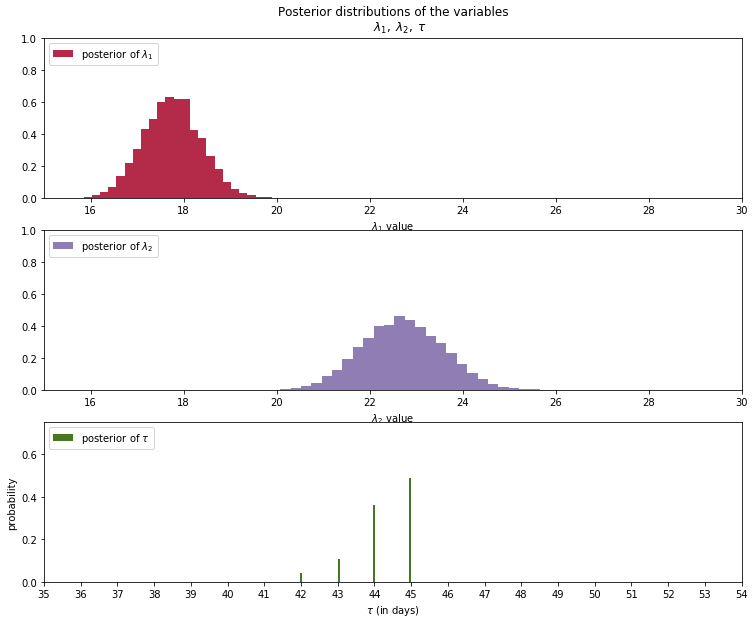

In [19]:
figsize(12.5, 10)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

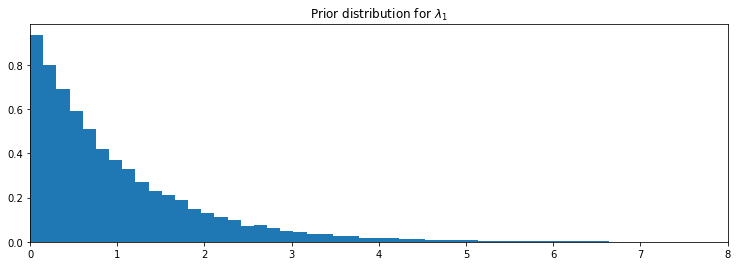

In [25]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
figsize(12.5, 4)

lambda_1 = pm.Exponential("lambda_1", 1) 
samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")

plt.title("Prior distribution for $\lambda_1$")

plt.xlim(0, 8);

In [26]:
data = np.array([10, 5])
fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print("value: ", fixed_variable.value)
print("calling .random()")
fixed_variable.random()
print("value: ", fixed_variable.value)

value:  [10  5]
calling .random()
value:  [10  5]


In [29]:

lambda_1 = pm.Exponential("lambda_1", 1)  # prior on first behaviour
lambda_2 = pm.Exponential("lambda_2", 1)  # prior on second behaviour
tau = pm.DiscreteUniform("tau", lower=0, upper=10)  # prior on behaviour change

print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value, "\n")

lambda_1.random(), lambda_2.random(), tau.random()




print("After calling random() on the variables...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value)



import numpy as np
n_data_points = 5  # in CH1 we had ~70 data points


@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after tau is lambda2
    return out


# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print(obs.value)

lambda_1.value = 0.082
lambda_2.value = 0.910
tau.value = 9.000 

After calling random() on the variables...
lambda_1.value = 0.306
lambda_2.value = 0.845
tau.value = 8.000
[10 25 15 20 35]


In [60]:

tau = pm.rdiscrete_uniform(0, 80)
print(tau)

27


In [72]:

alpha = 1. / 20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print(lambda_1, lambda_2)
print(alpha)

25.5678362501 8.89898105858
0.05


In [73]:

data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
print(data)

[28 33 21 31 27 25 36 20 25 14 23 28 29 24 37 26 26 23 34 28 26 22 23 23 28
 27 26  7 10  8  6  4 11  8 10  8  8  2  6  8 11  8  9 11  6 11 10  9  6  5
  6 12  6 14  9 10  4 14 11 18  3  9  7 16  9 11 12  9  7  4  6 11  6 11 11
  7  7  6  6 13]


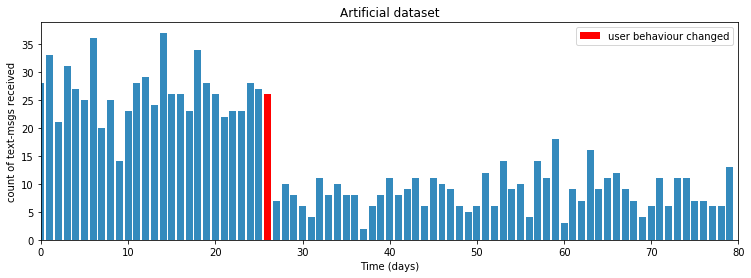

In [74]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();